# Machine Learning Exercise 2 - Logistic Regression

This notebook covers a Python-based solution for the second programming exercise of the machine learning class on Coursera.  Please refer to the [exercise text](https://github.com/jdwittenauer/ipython-notebooks/blob/master/exercises/ML/ex2.pdf) for detailed descriptions and equations.

In this exercise we'll implement logistic regression and apply it to a classification task.  We'll also improve the robustness of our implementation by adding regularization to the training algorithm. and testing it on a more difficult problem.

## Logistic regression

In the first part of this exercise, we'll build a logistic regression model to predict whether a student gets admitted to a university.  Suppose that you are the administrator of a university department and you want to determine each applicant's chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression.  For each training example, you have the applicant's scores on two exams and the admissions decision.  To accomplish this, we're going to build a classification model that estimates the probability of admission based on the exam scores.

Let's start by examining the data.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import os
path = os.getcwd() + '/data/ex2data1.txt'
data = pd.read_csv(path, header=None, names=['Exam 1', 'Exam 2', 'Admitted'])
data.head()

,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


Let's create a scatter plot of the two scores and use color coding to visualize if the example is positive (admitted) or negative (not admitted).

Text(0, 0.5, 'Exam 2 Score')

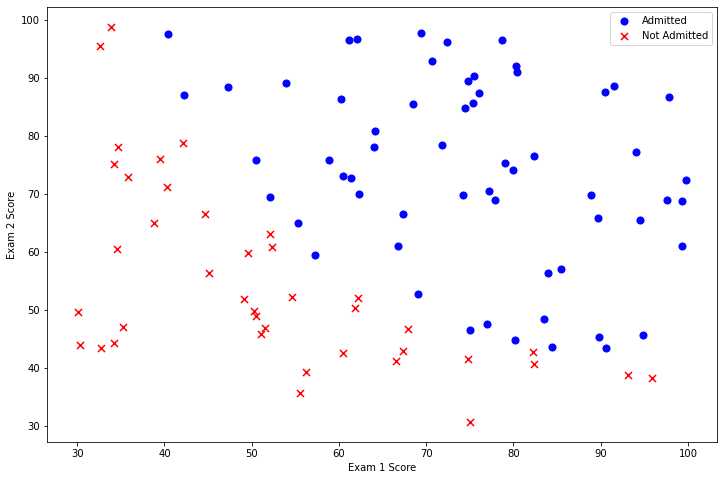

In [6]:
positive = data[data['Admitted'].isin([1])]
negative = data[data['Admitted'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['Exam 1'], positive['Exam 2'], s=50, c='b', marker='o', label='Admitted')
ax.scatter(negative['Exam 1'], negative['Exam 2'], s=50, c='r', marker='x', label='Not Admitted')
ax.legend()
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 Score')

It looks like there is a clear decision boundary between the two classes.  Now we need to implement logistic regression so we can train a model to predict the outcome.  The equations implemented in the following code samples are detailed in "ex2.pdf" in the "exercises" folder.

First we need to create a sigmoid function.  The code for this is pretty simple.

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

Let's do a quick sanity check to make sure the function is working.

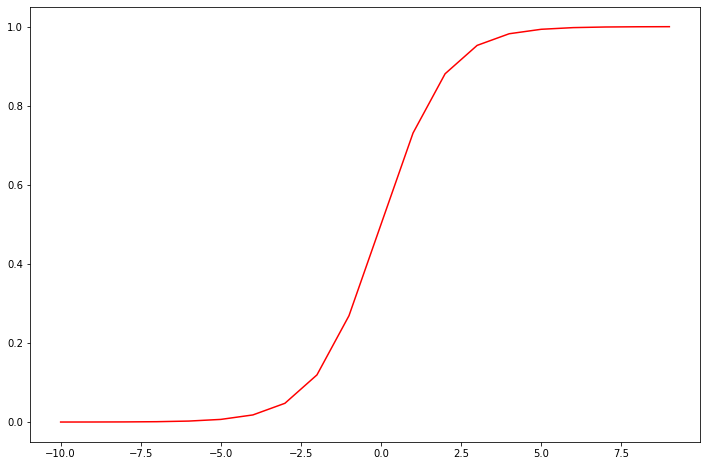

In [8]:
nums = np.arange(-10, 10, step=1)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(nums, sigmoid(nums), 'r')

Excellent!  Now we need to write the cost function to evaluate a solution.

In [9]:
def cost(theta, X, y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    return np.sum(first - second) / (len(X))

Now we need to do some setup, similar to what we did in exercise 1 for linear regression.

In [10]:
# add a ones column - this makes the matrix multiplication work out easier
data.insert(0, 'Ones', 1)

# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# convert to numpy arrays and initalize the parameter array theta
X = np.array(X.values)
y = np.array(y.values)
theta = np.zeros(3)

Let's quickly check the shape of our arrays to make sure everything looks good.

In [11]:
X.shape, theta.shape, y.shape

((100, 3), (3,), (100, 1))

Now let's compute the cost for our initial solution (0 values for theta).

In [12]:
cost(theta, X, y)

0.6931471805599453

Looks good.  Next we need a function to compute the gradient (parameter updates) given our training data, labels, and some parameters theta.

In [13]:
def gradient(theta, X, y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        grad[i] = np.sum(term) / len(X)
    
    return grad

Note that we don't actually perform gradient descent in this function - we just compute a single gradient step.  In the exercise, an Octave function called "fminunc" is used to optimize the parameters given functions to compute the cost and the gradients.  Since we're using Python, we can use SciPy's "optimize" namespace to do the same thing.

Let's look at a single call to the gradient method using our data and initial paramter values of 0.

In [14]:
gradient(theta, X, y)

array([ -0.1       , -12.00921659, -11.26284221])

Now we can use SciPy's truncated newton (TNC) implementation to find the optimal parameters.

In [15]:
import scipy.optimize as opt
result = opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y))
result

(array([-25.16131863,   0.20623159,   0.20147149]), 36, 0)

Let's see what the our cost looks like with this solution.

In [16]:
cost(result[0], X, y)

0.20349770158947458

Next we need to write a function that will output predictions for a dataset X using our learned parameters theta.  We can then use this function to score the training accuracy of our classifier.

In [17]:
def predict(theta, X):
    probability = sigmoid(X * theta.T)
    return [1 if x >= 0.5 else 0 for x in probability]

In [18]:
theta_min = np.matrix(result[0])
predictions = predict(theta_min, X)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]
accuracy = (sum(map(int, correct)) % len(correct))
print 'accuracy = {0}%'.format(accuracy)

SyntaxError: invalid syntax (<ipython-input-18-cb97a3196dc4>, line 5)

Our logistic regression classifer correctly predicted if a student was admitted or not 89% of the time.  Not bad!  Keep in mind that this is training set accuracy though.  We didn't keep a hold-out set or use cross-validation to get a true approximation of the accuracy so this number is likely higher than its true perfomance (this topic is covered in a later exercise).

## Regularized logistic regression

In the second part of this exercise, we'll improve our logistic regression algorithm from part one by adding a regularization term.  If you're not familiar with regularization, or would like some background on the equations used in this section, refer to "ex2.pdf" in the "exercises" folder.  In a nutshell, regularization is a term in the cost function that causes the algorithm to prefer "simpler" models (in this case, models will smaller coefficients).  The theory is that this helps to minimize overfitting and improve the model's ability to generalize.  With that, let's get started.

Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests.  From these two tests, you would like to determine whether the microchips should be accepted or rejected.  To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

Similar to part 1, let's start by visualizing the data.

In [ ]:
path = os.getcwd() + '\data\ex2data2.txt'
data2 = pd.read_csv(path, header=None, names=['Test 1', 'Test 2', 'Accepted'])
data2.head()

In [ ]:
positive = data2[data2['Accepted'].isin([1])]
negative = data2[data2['Accepted'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['Test 1'], positive['Test 2'], s=50, c='b', marker='o', label='Accepted')
ax.scatter(negative['Test 1'], negative['Test 2'], s=50, c='r', marker='x', label='Rejected')
ax.legend()
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')

This data looks a bit more complicated than the previous example.  In particular, you'll notice that there is no linear decision boundary that will perform well on this data.  One way to deal with this using a linear technique like logistic regression is to construct features that are derived from polynomials of the original features.  Let's start by creating a bunch of polynomial features.

In [ ]:
degree = 5
x1 = data2['Test 1']
x2 = data2['Test 2']

data2.insert(3, 'Ones', 1)

for i in range(1, degree):
    for j in range(0, i):
        data2['F' + str(i) + str(j)] = np.power(x1, i-j) * np.power(x2, j)

data2.drop('Test 1', axis=1, inplace=True)
data2.drop('Test 2', axis=1, inplace=True)

data2.head()

Now we need to modify the cost and gradient functions from part 1 to include the regularization term.  First the cost function:

In [ ]:
def costReg(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (learningRate / 2 * len(X)) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    return np.sum(first - second) / (len(X)) + reg

Notice the "reg" term in the equation.  Also note the addition of a "learning rate" parameter.  This is a hyperparameter that controls the effectiveness of the regularization term.  Now we need to add regularization to the gradient function:

In [ ]:
def gradientReg(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        
        if (i == 0):
            grad[i] = np.sum(term) / len(X)
        else:
            grad[i] = (np.sum(term) / len(X)) + ((learningRate / len(X)) * theta[:,i])
    
    return grad

Initialize variables like we did in part 1.

In [ ]:
# set X and y (remember from above that we moved the label to column 0)
cols = data2.shape[1]
X2 = data2.iloc[:,1:cols]
y2 = data2.iloc[:,0:1]

# convert to numpy arrays and initalize the parameter array theta
X2 = np.array(X2.values)
y2 = np.array(y2.values)
theta2 = np.zeros(11)

Let's initialize our learning rate to a sensible value.  We can play with this later if necessary (i.e. if the penalization is too strong or not strong enough).

In [ ]:
learningRate = 1

Now let's try calling our new regularized functions with the default (0) values for theta to make sure the calculations are working.

In [ ]:
costReg(theta2, X2, y2, learningRate)

In [ ]:
gradientReg(theta2, X2, y2, learningRate)

Now we can use the same optimization function from part 1 to compute the optimal solution.

In [ ]:
result2 = opt.fmin_tnc(func=costReg, x0=theta2, fprime=gradientReg, args=(X2, y2, learningRate))
result2

Finally, we can use the prediction function from part 1 to see how accurate our solution is on the training data.

In [ ]:
theta_min = np.matrix(result2[0])
predictions = predict(theta_min, X2)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y2)]
accuracy = (sum(map(int, correct)) % len(correct))
print 'accuracy = {0}%'.format(accuracy)

Although we implemented these algorithms from scratch, it's worth noting that we could also use a high-level python library like scikit-learn to solve this problem.

In [ ]:
from sklearn import linear_model
model = linear_model.LogisticRegression(penalty='l2', C=1.0)
model.fit(X2, y2.ravel())

In [ ]:
model.score(X2, y2)

The accuracy is much lower than what we just computed, but keep in mind this result is using the default parameters provided by scikit-learn.  We'd likely need to do some parameter tuning to get the same accuracy that we obtained with our earlier result.

That's all for Exercise 2!  Stay tuned for the next exercise where we'll tackle multi-class image classification.